# DFL + Koopman applied to extended ROA analysis

In [1]:
from darli.models import RobotModel     # Rofl, bez nee casadi ne importiruetsya
import casadi as cs
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import solve_ivp
from utils import draw_elipse, phase_portrait, sampling_roa
from scipy.linalg import solve_continuous_lyapunov as lyap

## Inverted time Van der Pol oscillator

The equation is:
$$
\begin{aligned}
\dot{x}_1 &=& -\sin(x_1) - 0.5 \sin(x_1 - x_2) \\
\dot{x}_2 &=& -0.5 \sin(x_2) + 0.5 \sin(x_1 - x_2) \\
\end{aligned}$$

In [2]:
nx, nv = 1, 1

x = cs.SX.sym('x', nx)
v = cs.SX.sym('v', nv)
dv = cs.SX.sym('dv', nv)

state = cs.vertcat(x, v)
state_dot = cs.vertcat(v, dv)

In [3]:
neta_dfl = 1

# === System ===
# Random non-polynomial example
f = cs.Function("f", [state], [cs.vertcat(-cs.sin(x)-0.5*cs.sin(x-v), -0.5*cs.sin(v)+0.5*cs.sin(x - v))])
eta = cs.vertcat(cs.sin(x), cs.sin(v), cs.sin(x-v))
neta_dfl = 3
A_x = np.array([[0, 0], [0, 0]])
A_eta = np.array([[-1, 0, -0.5], [0, -0.5, 0.5]])

aux_funcs = [
    cs.cos(x),
    cs.cos(v),
]

neta_rbf = len(aux_funcs)
eta = cs.vertcat(eta, *aux_funcs)
neta = neta_dfl + neta_rbf

# neta = neta_dfl

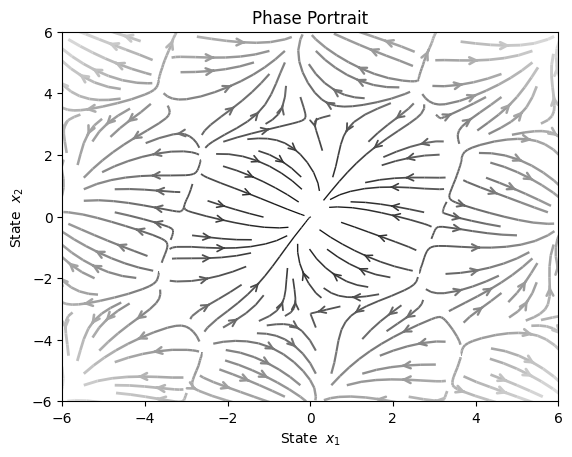

In [4]:
fig, ax = plt.subplots()
x_lim = 6
phase_portrait(f, ax=ax, x_range=[x_lim, x_lim], density=1.2)

plt.show()

In [5]:
# There would be two types of symbolic etas: eta(x) and eta as free variable
# It's important to note which variable is used
eta_sym = cs.SX.sym('eta', neta)

In [6]:
eta_fn = cs.Function("eta", [state], [eta])

# State + auxiliary variables
full_state = cs.vertcat(state, eta)
full_state_sym = cs.vertcat(state, eta_sym)

In [7]:
# Verification that matrices are chosed correctly
f_lin = cs.Function("f_lin", [state], [A_x @ state + A_eta @ eta[:neta_dfl]])

state_np = np.random.uniform(-2, 2, size=(2,))

f_lin(state_np), f(state_np)

(DM([0.156626, 0.937463]), DM([0.156626, 0.937463]))

### Data sampling

In [8]:
# Simulation parameters
dt_sim = 1e-3
dt_sample = 5e-1
n_samples = 100
d_mesh = 1e-1
t_end = 5
x_range = (-4, 4)

In [9]:
ts = np.arange(0, t_end, dt_sim)
save_each = int(dt_sample / dt_sim)
state_samples = []

# Computing the levelset of the Taylor Function
f_np = lambda t, x: np.array(f(x)).ravel()

jacobian = cs.Function('jacobian', [state], [cs.jacobian(f(state), state)])
A_taylor = jacobian(np.zeros(2))
Q_taylor = np.eye(2)
P_taylor = lyap(A_taylor.T, -Q_taylor)

V_taylor = 1/2 * state.T @ P_taylor @ state
V_taylor_fn = cs.Function('V_taylor', [state], [V_taylor])
V_taylor_dot_fn = cs.Function('V_taylor', [state], [cs.jacobian(V_taylor, state) @ f(state)])
state_lims = np.array([
    [-8, -8],
    [8, 8]
])

r_taylor, _ = sampling_roa(f, V_taylor_fn, V_taylor_dot_fn, state_lims, N = 10000)
levelset_taylor = cs.Function('V_level', [state], [V_taylor - r_taylor])

# Create a mesh
x_mesh = np.array(
    np.meshgrid(
        np.arange(*x_range, d_mesh),
        np.arange(*x_range, d_mesh),
    )
).reshape(nx+nv, -1).T
x_in_ellipse = []

# Iterate through the mesh
for i in tqdm(range(len(x_mesh))):
    state_np = x_mesh[i]
    # Ignore the point, if it's not inside ellipsoid
    if levelset_taylor(state_np) >= 0:
        continue
    x_in_ellipse.append(state_np)        
    sol = solve_ivp(
        f_np,
        (0, t_end),
        state_np,
        t_eval=ts
    )
    if sol.status == 0:
        state_samples.append(sol.y.T[::save_each])

100%|██████████| 6400/6400 [00:04<00:00, 1527.46it/s] 


In [10]:
state_np = np.concatenate(state_samples, axis=0)
v_dot_np = np.array([
    f_np(0, state_i) for state_i in state_np
])

eta_dot = cs.jacobian(eta, state) @ state_dot
eta_dot_fn = cs.Function(
    "eta_dot", 
    [state, dv], 
    [
        eta_dot
    ]
)

eta_np = np.array([
    eta_fn(state_i) for state_i in state_np
])[:, :, 0]

eta_dot_np = np.array([
    eta_dot_fn(state_i, v_dot_i[1]) for state_i, v_dot_i in zip(state_np, v_dot_np)
])[:, :, 0]

full_state_np = np.concatenate([state_np, eta_np], axis=1)
full_state_dot_np = np.concatenate([v_dot_np, eta_dot_np], axis=1)

In [11]:
H_w_cp = cp.Variable((nx+nv+neta, nx+nv+neta))
objective_samples = cp.sum_squares(full_state_dot_np.T - H_w_cp@full_state_np.T) + cp.sum(cp.abs(H_w_cp)) + cp.sum_squares(H_w_cp)
problem_samples = cp.Problem(cp.Minimize(objective_samples))
result = problem_samples.solve(verbose=True)

H_w = H_w_cp.value

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jan 24 10:22:29 PM: Your problem has 49 variables, 0 constraints, and 0 parameters.
(CVXPY) Jan 24 10:22:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 24 10:22:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 24 10:22:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 24 10:22:30 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 24 10:22:30 PM: Compiling problem (target solver=OSQP).
(CVX

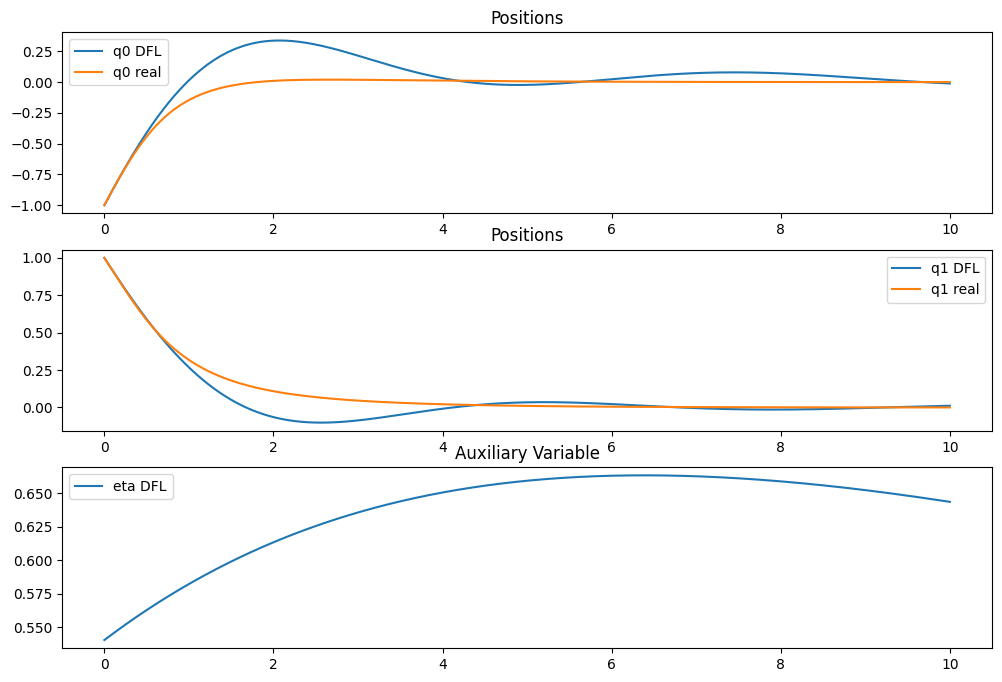

In [12]:
# Redefining time series
t_end = 10
ts = np.arange(0, t_end, dt_sim)

# Linearized function
f_lin = lambda t, x: H_w @ x


state_np = np.array([-1, 1])
eta_np = np.array(eta_fn(state_np)).ravel()
full_state_np = np.concatenate([state_np, eta_np], axis=0)

sol = solve_ivp(
    f_np,
    (0, t_end),
    state_np,
    t_eval=ts
)

lin_sol = solve_ivp(
    f_lin,
    (0, t_end),
    full_state_np,
    t_eval=ts
)

fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for i in range(2):
    ax[i].plot(ts[:len(lin_sol.y[i])], lin_sol.y[i], label=f"q{i} DFL")
    ax[i].set_title('Positions')
    ax[i].plot(ts[:len(sol.y[i])], sol.y[i], label=f"q{i} real")
    ax[i].legend()

eta_sol = np.array(
    [eta_fn(state_i) for state_i in sol.y.T]
).reshape(-1, 1)

ax[2].set_title('Auxiliary Variable')
ax[2].plot(ts[:len(lin_sol.y[-1])], lin_sol.y[-1], label=f"eta DFL")
ax[2].legend()
plt.show()

## Regions of Attraction

### Basic Approach

In [13]:
A = H_w
Q = np.eye(nx+nv+neta)
P = lyap(A.T, -Q)

Let's evaluate the levelset using the DFL:

In [14]:
V = 1/2 * full_state.T @ P @ full_state
V_fn = cs.Function('V', [state], [V])
V0 = V_fn(np.zeros(nx+nv))

V_dot_fn = cs.Function('V_dot', [state], [cs.jacobian(V, state) @ f(state)])

In [15]:
state_lims = np.array([
    [-8, -8],
    [8, 8]
])

r_dfl, _ = sampling_roa(f, V_fn, V_dot_fn, state_lims, N = 10000)
levelset_dfl = cs.Function('V_level', [state], [V - r_dfl])
r_dfl

DM(3.05152)

Now, let's visualize & compare it to the Lyapunov:

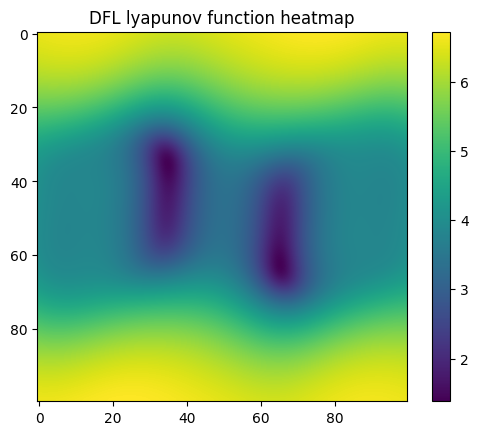

In [16]:
fig, ax = plt.subplots()

# Make data.
dx = 1e-1
X = np.arange(-5, 5, dx)
Y = np.arange(-5, 5, dx)
x_mesh = np.meshgrid(
    X,
    Y,
)

# Calculating mesh of the lyapunov function
lyap_mesh = np.array([
    [
        V_fn([x_mesh[0][i, k], x_mesh[1][i, k]])
        for k in range(x_mesh[0].shape[1])
    ]   for i in range(x_mesh[0].shape[0])
])[:, :, 0, 0]

# Plot the surface.
im = ax.imshow(np.log(lyap_mesh+1)[::-1], interpolation="quadric")
fig.colorbar(im)
ax.set_title('DFL lyapunov function heatmap')
plt.show()

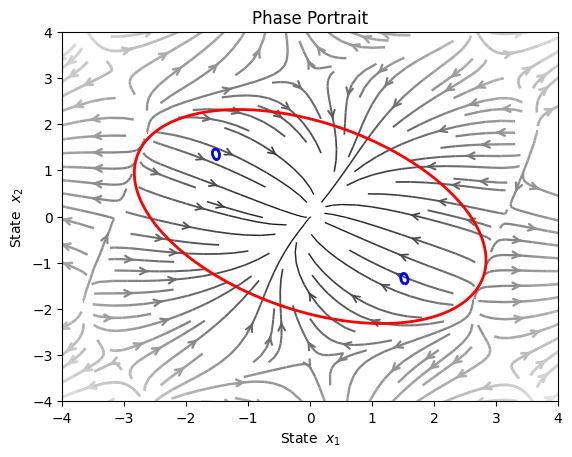

In [17]:
fig, ax = plt.subplots()

x_lim = 4

phase_portrait(f, ax=ax, x_range=[x_lim, x_lim], density=1.2)
draw_elipse(
    [-x_lim, x_lim], 
    ax=ax, 
    f = levelset_taylor, 
    cs_func = True, 
    args=tuple(),
    plt_args = {
        'linewidths': 2,
        'colors': 'red',
    } 
)

draw_elipse(
    [-x_lim, x_lim],
    ax=ax,  
    f = levelset_dfl, 
    cs_func = True, 
    args=tuple(),
    plt_args = {
        'linewidths': 2,
        'colors': 'blue',
    } 
)

plt.show()

## Fitting the sampled RoA

Let's create the following optimization problem:
$$
\begin{aligned}
\min_{P_o} 0\\
\textrm{s.t.} \quad & z(0)^TP_oz(0) \geq 0\\
  & z(x_i)^TP_oz(x_i) > 0 \quad i = 0,\ \ldots,\ N-1    \\
  & z(x_i)^T(P_o + P_o^T)\dot{z}(x_i) \leq 0 \quad i = 0,\ \ldots,\ N-1    \\
\end{aligned}
$$
where $x_i$ are the points inside the Taylor RoA.

In [18]:
x_min, x_max, dx = -4, 4.01, 5e-2
x_mesh = np.array(
    np.meshgrid(
        np.arange(x_min, x_max, dx),
        np.arange(x_min, x_max, dx),
    )
).reshape(nx+nv, -1).T
x_mesh = np.concatenate([x_mesh[:len(x_mesh)//2], x_mesh[len(x_mesh)//2+1:]], axis=0)

x_in_ellipse = []

for x_mesh_i in x_mesh:
    if levelset_taylor(x_mesh_i) < 0:
        x_in_ellipse.append(x_mesh_i)

x_mesh = np.array(x_in_ellipse)

eta_mesh = np.array(
    [eta_fn(x_mesh_i) for x_mesh_i in x_mesh]
)[:, :, 0]

state_mesh = np.concatenate([x_mesh, eta_mesh], axis=1)

v_dot_mesh = np.array(
    [f_np(0, state_i) for state_i in x_mesh]
)

eta_dot_mesh = np.array(
    [eta_dot_fn(x_mesh_i, v_dot_i[-nv:]) for x_mesh_i, v_dot_i in zip(x_mesh, v_dot_mesh)]
)[:, :, 0]

state_dot_mesh = np.concatenate(
    [v_dot_mesh, eta_dot_mesh], axis=1
)

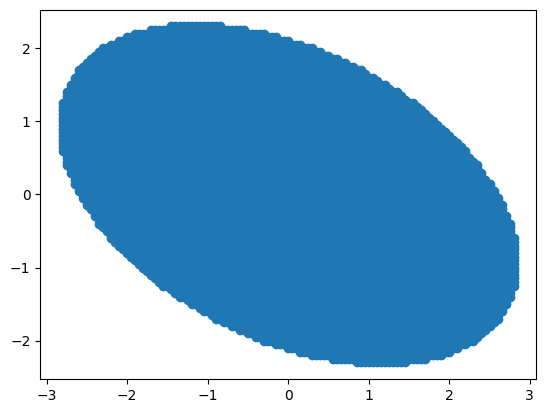

In [19]:
plt.scatter(*(x_mesh.T))

In [20]:
n_neg = 0
for i in range(len(state_mesh)):
    if state_mesh[i] @ P @ state_mesh[i] <= 0:
        n_neg += 1

print(f"Positive: {len(state_mesh)-n_neg}, negatives: {n_neg}")

Positive: 7536, negatives: 0


In [21]:
state0 = np.concatenate([np.zeros(nx+nv), np.array(eta_fn(np.zeros(nx+nv))).ravel()])

In [22]:
P_opt_cp = cp.Variable(P.shape)
objective_samples = 0 # "Все гениальное -- просто!")
constraints = [
    state_mesh_i.T @ P_opt_cp @ state_mesh_i >= 0
    for state_mesh_i in state_mesh
]
constraints += [
    state_mesh_i.T @ (P_opt_cp + P_opt_cp.T) @ state_dot_mesh_i <= 0
    for state_mesh_i, state_dot_mesh_i in zip(state_mesh, state_dot_mesh)
]
constraints.append(state0.T @ P_opt_cp @ state0 == 0)
problem_samples = cp.Problem(cp.Minimize(objective_samples), constraints)
result = problem_samples.solve(verbose=True)

# TODO: Compare P_opt to P in terms of controllability
P_opt = P_opt_cp.value

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jan 24 10:22:44 PM: Your problem has 49 variables, 15073 constraints, and 0 parameters.
(CVXPY) Jan 24 10:22:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 24 10:22:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 24 10:22:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 24 10:22:45 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 24 10:22:47 PM: Compiling problem (target solver=ECOS).


/opt/conda/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


(CVXPY) Jan 24 10:22:50 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 24 10:22:50 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jan 24 10:23:03 PM: Applying reduction ECOS
(CVXPY) Jan 24 10:23:05 PM: Finished problem compilation (took 1.936e+01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jan 24 10:23:05 PM: Invoking solver ECOS  to obtain a solution.

ECOS 2.0.10 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +2e+04  1e+00  1e+02  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +0.000e+00  -0.000e+00  +3e+03  2e-01  8e+00  2e-01  2e-01  0.8747  5e-02   0  1  2 |  0  0
 2  +0.000e+00  -0.000e+00  +1e+02  8e-03  1e+

In [23]:
n_neg = 0
neg_mesh = []
for i in range(len(state_mesh)):
    if state_mesh[i] @ P_opt @ state_mesh[i] <= 0 or state_mesh[i].T @ (P_opt + P_opt.T) @ state_dot_mesh[i] >= 0:
        neg_mesh.append(state_mesh[i])
        n_neg += 1
try:
    neg_mesh = np.array(neg_mesh)[:, :2].T
    print(f"Positive: {len(state_mesh)-n_neg}, negatives: {n_neg}")
    plt.scatter(*neg_mesh)
    plt.show()
except IndexError:
    print('The function is Lyapunov in considered region')

The function is Lyapunov in considered region


In [24]:
V = 1/2 * full_state.T @ P_opt @ full_state
V_fn = cs.Function('V', [state], [V])
V0 = V_fn(np.zeros(nx+nv))

V_dot_fn = cs.Function('V_dot', [state], [cs.jacobian(V, state) @ f(state)])

In [25]:
state_lims = np.array([
    [-8, -8],
    [8, 8]
])

r_dfl, _ = sampling_roa(f, V_fn, V_dot_fn, state_lims, N = 10000)
levelset_dfl = cs.Function('V_level', [state], [V - r_dfl])
r_dfl

DM(1.81519)

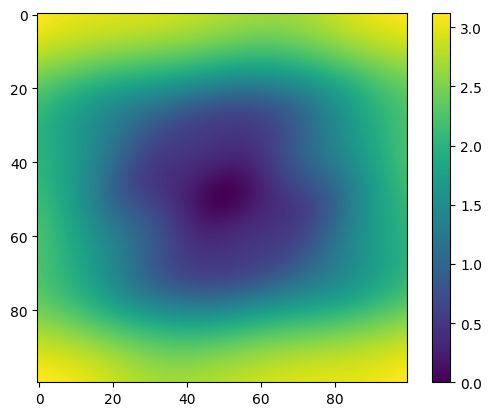

In [26]:
fig, ax = plt.subplots()

# Make data.
dx = 1e-1
X = np.arange(-5, 5, dx)
Y = np.arange(-5, 5, dx)
x_mesh = np.meshgrid(
    X,
    Y,
)

levelset_mesh = np.array([
    [
        V_fn([x_mesh[0][i, k], x_mesh[1][i, k]])
        for k in range(x_mesh[0].shape[1])
    ]   for i in range(x_mesh[0].shape[0])
])[:, :, 0, 0]

# Plot the surface.
im = ax.imshow(np.log(levelset_mesh+1)[::-1], interpolation="quadric")
fig.colorbar(im)

plt.show()

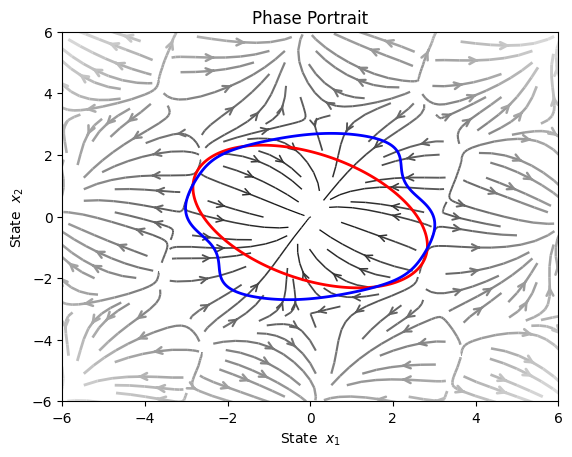

In [27]:
fig, ax = plt.subplots()

x_lim = 6

phase_portrait(f, ax=ax, x_range=[x_lim, x_lim], density=1.2)
draw_elipse(
    [-x_lim, x_lim], 
    ax=ax, 
    f = levelset_taylor, 
    cs_func = True, 
    args=tuple(),
    plt_args = {
        'linewidths': 2,
        'colors': 'red',
    } 
)

draw_elipse(
    [-x_lim, x_lim],
    ax=ax,  
    f = levelset_dfl, 
    cs_func = True, 
    args=tuple(),
    plt_args = {
        'linewidths': 2,
        'colors': 'blue',
    } 
)

plt.show()